In [171]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.display import Image
import scipy.ndimage
import glob
import os

In [172]:
cd "/home/tushara/Documents/projects/phylab/elegans/data/exp1/trial2/complete_data/"

/home/tushara/Documents/projects/phylab/elegans/data/exp1/trial2/complete_data


In [173]:
reference_img = cv2.imread("/home/tushara/Documents/projects/phylab/elegans/data/exp1/trial2/complete_data/MA2_0001.JPG", 0)

worm1 = reference_img[1300:1600, 2200:2600]
worm2 = reference_img[1200:1600, 1550:1850]

# reference for worm 1
ret, bin_worm1 = (cv2.threshold(worm1, 110, 255, cv2.THRESH_BINARY))
bin_worm1 = np.uint8(~scipy.ndimage.binary_fill_holes(~bin_worm1))*255
worm1_contour, hierarchy = cv2.findContours(cv2.bitwise_not(bin_worm1), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) 
worm1_area = cv2.contourArea(max(worm1_contour, key=cv2.contourArea))
worm1_length = len(max(worm1_contour, key=cv2.contourArea))

# reference for worm 2
ret, bin_worm2 = (cv2.threshold(worm2, 90, 255, cv2.THRESH_BINARY))
bin_worm2 = np.uint8(~scipy.ndimage.binary_fill_holes(~bin_worm2))*255
worm2_contour, hierarchy = cv2.findContours(cv2.bitwise_not(bin_worm2), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) 
worm2_area = cv2.contourArea(max(worm2_contour, key=cv2.contourArea))
worm2_length = len(max(worm2_contour, key=cv2.contourArea))

In [199]:
def analysis(img):

    # note, all these separation of algorithm by image sets wont be necessary if the images have no difference
    if int(os.path.basename(path).split('_')[1].split('.')[0]) <= 1782: # this i have to do because two sets of data were collected separately and one set is zoomed in -- so the cropping has to be different
        cell = img[750:2350, 1500:3000] 

        cell_radius = 705
        cell_center = (720,805)
        mask = cv2.circle(np.zeros(cell.shape[:2],dtype=np.uint8), cell_center, cell_radius, (255,255,255), -1) # this creates an empty template of (255,255,255) (white) circle with outside parts as black.
        masked_cell = np.full_like(cell, 255) # this creates another template of full white
        masked_cell[mask!=0] = cell[mask!=0] # in the full white template, this then finds the region of the empty white circle and equates it to the same region of the cell image, giving image cropped with white outside
        
    else: # have to put the masking also inside because the magnification shifts the center of the masked cell
        cell = img[580:2500, 1375:3200] # just like before, i manually cropped the image to fit the cell perfectly
        
        cell_radius = 852 # to obtain this, i assumed that the two cells look the same, therefore the scaling of the dimensions of the cells must follow that of the radius and the center. 2350-750 = 1600; 3000-1500 = 1500; 3200-1375 = 1825; 2500-580 = 1920; 1920/1600 = 1.2; 1825/1500 = 1.22; avg(1.2,1.22)*old radius = new radius; (1.2*old center(x),1.22*old center(y)) = (new center(x), new center(y))
        cell_center = (876, 966)
        mask = cv2.circle(np.zeros(cell.shape[:2],dtype=np.uint8), cell_center, cell_radius, (255,255,255), -1) # this creates an empty template of (255,255,255) (white) circle with outside parts as black.
        masked_cell = np.full_like(cell, 255) # this creates another template of full white
        masked_cell[mask!=0] = cell[mask!=0] # in the full white template, this then finds the region of the empty white circle and equates it to the same region of the cell image, giving image cropped with white outside
    
    ret, bin_cell = (cv2.threshold(masked_cell, 90, 255, cv2.THRESH_BINARY))
    
    # defining the contour
    contours, hierarchy = cv2.findContours(cv2.bitwise_not(bin_cell), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    tolerance = 0.50
    min_area = np.average([worm1_area,worm2_area]) * (1-tolerance) 
    max_area = np.average([worm1_area,worm2_area]) * (1+tolerance)
    
    worms_contour = [c for c in contours if min_area <= cv2.contourArea(c) <= max_area]
    c_worms = cv2.cvtColor(bin_cell, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(c_worms, worms_contour, -1, (0, 255, 0), 2)

    # finding the distance 
    centers = []
    distance = np.nan
    if len(worms_contour) == 2:
        for i in range(len(worms_contour)):
            moments = cv2.moments(worms_contour[i])
            centers.append((int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00'])))
            cv2.circle(c_worms, centers[-1], 10, (255, 0, 0), -1)
        distance = math.dist(centers[0], centers[1])

    elif len(worms_contour) == 1:
        for i in range(len(worms_contour)):
            moments = cv2.moments(worms_contour[i])
            centers.append((int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00'])))
            cv2.circle(c_worms, centers[-1], 10, (255, 0, 0), -1)
        center_tolerance = 150 # i.e. if the COM falls within this range, then assume the worm to be at the center and let the distance between the two worms be = radius of the cell
        # value chosen as to what seemed the best to me
        
        if (cell_center[0] - center_tolerance <= centers[0][0] <= cell_center[0] + center_tolerance) and (cell_center[1] - center_tolerance <= centers[0][1] <= cell_center[1] + center_tolerance):
            distance = cell_radius
        else: 
            distance = np.nan

    else:
        distance = np.nan

    return distance, centers, c_worms, cell, worms_contour, cell_radius, cell_center

[(857, 660), (688, 595)]


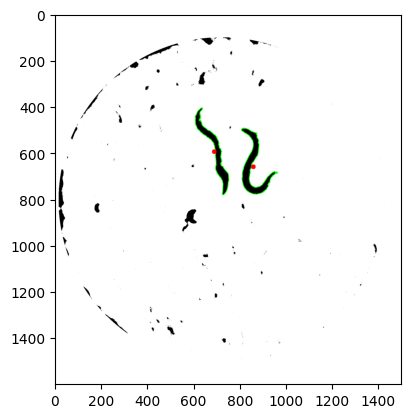

181.06904760339356


In [225]:
path = "/home/tushara/Documents/projects/phylab/elegans/data/exp1/trial2/complete_data/MA2_0147.JPG"
img = cv2.imread(path, 0)
print(analysis(img)[1])
plt.imshow(analysis(img)[2], cmap = "gray") # change the index to 1 and see what happens!!! -- i.e. if 1 corresponds to the returned centers value
plt.show()
print(analysis(img)[0])
#print(analysis(img)[4])

In [203]:
'''fps = 30
paths = sorted(glob.glob("*.JPG"))
times = []
distances = []
for i, path in enumerate(paths):
    img = cv2.imread(path, 0)
    
    if img is None: # there are some corrupted images where I am putting NaN as the data
        times.append(i/fps)
        distances.append(np.nan)
        print("printed nan")
        continue
        
    times.append(i/fps)
    distances.append(analysis(img)[0] if analysis(img)[0] is not None else np.nan)
    
    if i % 100 == 0:
        print(f"Processed {i}/{len(paths)} frames ({i/len(paths)*100:.1f}%)")'''

Processed 0/3582 frames (0.0%)
Processed 100/3582 frames (2.8%)
Processed 200/3582 frames (5.6%)
Processed 300/3582 frames (8.4%)
Processed 400/3582 frames (11.2%)
Processed 500/3582 frames (14.0%)
printed nan
printed nan
Processed 600/3582 frames (16.8%)
Processed 700/3582 frames (19.5%)
Processed 800/3582 frames (22.3%)
Processed 900/3582 frames (25.1%)
Processed 1000/3582 frames (27.9%)
Processed 1100/3582 frames (30.7%)
printed nan
printed nan
Processed 1200/3582 frames (33.5%)
Processed 1300/3582 frames (36.3%)
printed nan
Processed 1400/3582 frames (39.1%)
Processed 1500/3582 frames (41.9%)
Processed 1600/3582 frames (44.7%)
Processed 1700/3582 frames (47.5%)
printed nan
Processed 1800/3582 frames (50.3%)
Processed 1900/3582 frames (53.0%)
Processed 2000/3582 frames (55.8%)
Processed 2100/3582 frames (58.6%)
Processed 2200/3582 frames (61.4%)
printed nan
Processed 2300/3582 frames (64.2%)
Processed 2400/3582 frames (67.0%)
Processed 2500/3582 frames (69.8%)
Processed 2600/3582 fr

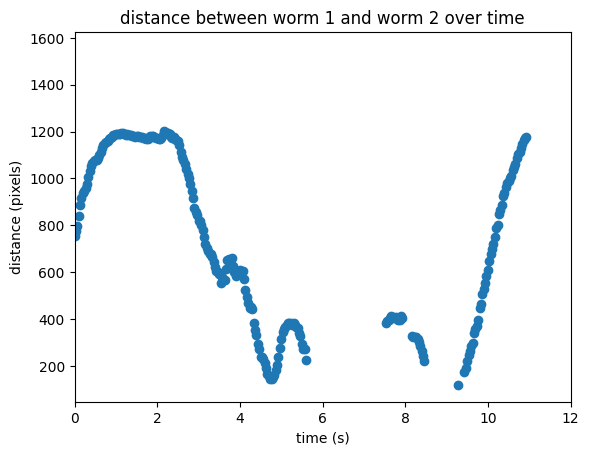

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_w = pd.DataFrame({"time": times, "distance": distances})
data_w.to_csv("/home/tushara/Documents/projects/phylab/elegans/analysis_code/analyzed_data/distance_over_time_new.csv", index = False)

data_r = pd.read_csv("/home/tushara/Documents/projects/phylab/elegans/analysis_code/analyzed_data/distance_over_time_new.csv", header=0)
ts = data_r.iloc[:,0].values
ds = data_r.iloc[:,1].values

plt.scatter(ts, ds)
plt.xlabel("time (s)")
plt.ylabel("distance (pixels)")
max_range = 12
plt.xlim(0, max_range)
plt.title("distance between worm 1 and worm 2 over time")
plt.savefig("/home/tushara/Documents/projects/phylab/elegans/analysis_code/images/12_sec_plot_new.png")
plt.show()

In [205]:
'''# this code is to identify the last image that was used in the range given for the plotting
time = []
for i in ts:
    if i<max_range:
        time.append(i)

distance = []
for i in range(len(time)):
    distance.append(ds[i])

end_distance = 0
for j in distance[::-1]:
    if np.isnan(j) == False:
        end_distance += j
        break

end_time = ts[distance.index(end_distance)]
print(end_time, end_distance)'''

'# this code is to identify the last image that was used in the range given for the plotting\ntime = []\nfor i in ts:\n    if i<max_range:\n        time.append(i)\n\ndistance = []\nfor i in range(len(time)):\n    distance.append(ds[i])\n\nend_distance = 0\nfor j in distance[::-1]:\n    if np.isnan(j) == False:\n        end_distance += j\n        break\n\nend_time = ts[distance.index(end_distance)]\nprint(end_time, end_distance)'

In [233]:
# this is to draw distance line b/w the worms and export the image
# this code only ouputs the images that have no lost worms

paths = sorted(glob.glob("*.JPG"))
for i, path in enumerate(paths):
    img = cv2.imread(path, 0)
    if img is not None:
        if len(analysis(img)[4]) == 2: # for when worms get lost, i can't draw the line.    
            two_worms = cv2.line(analysis(img)[3], analysis(img)[1][0], analysis(img)[1][1], (255,0,0), 5)
            if ~np.isnan(analysis(img)[0]):
                try:
                    text_worms = cv2.putText(two_worms, str(int(np.round(analysis(img)[0])))+"px", (int((analysis(img)[1][0][0] + analysis(img)[1][1][0])/2), int((analysis(img)[1][0][1] + analysis(img)[1][1][1])/2)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255),2,cv2.LINE_AA)
                    cv2.imwrite(os.path.join("/home/tushara/Documents/projects/phylab/elegans/analysis_code/images/new_worms_new/", os.path.basename(path)), text_worms)
                except IndexError: 
                    pass
        if (len(analysis(img)[4]) == 1) and analysis(img)[0] == analysis(img)[5]: 
            two_worms = cv2.line(analysis(img)[3], analysis(img)[1][0], (analysis(img)[1][0][0]+analysis(img)[5],analysis(img)[1][0][1]), (255,0,0), 5)
            if ~np.isnan(analysis(img)[0]):
                try: # idk why there this error coming for image 0147; ignoring for now.
                    text_worms = cv2.putText(two_worms, str(int(np.round(analysis(img)[5])))+"px", (int((analysis(img)[1][0][0]+(analysis(img)[1][0][0]+analysis(img)[5]))/2), analysis(img)[1][0][1]), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255),2,cv2.LINE_AA)
                    cv2.imwrite(os.path.join("/home/tushara/Documents/projects/phylab/elegans/analysis_code/images/new_worms_new/", os.path.basename(path)), text_worms)
            except IndexError:
                pass
        else:
            plt.imsave("/home/tushara/Documents/projects/phylab/elegans/analysis_code/images/new_worms_new/" + os.path.basename(path), analysis(img)[3], cmap='gray')
    if i % 100 == 0:
        print(f"Processed {i}/{len(paths)} frames ({i/len(paths)*100:.1f}%)")
print("done")

#to combine images into video: 
#ffmpeg -framerate 30 -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p out.mp4

Processed 0/3582 frames (0.0%)
Processed 100/3582 frames (2.8%)
Processed 200/3582 frames (5.6%)
Processed 300/3582 frames (8.4%)
Processed 400/3582 frames (11.2%)
Processed 500/3582 frames (14.0%)
Processed 600/3582 frames (16.8%)
Processed 700/3582 frames (19.5%)
Processed 800/3582 frames (22.3%)
Processed 900/3582 frames (25.1%)
Processed 1000/3582 frames (27.9%)
Processed 1100/3582 frames (30.7%)
Processed 1200/3582 frames (33.5%)
Processed 1300/3582 frames (36.3%)
Processed 1400/3582 frames (39.1%)
Processed 1500/3582 frames (41.9%)
Processed 1600/3582 frames (44.7%)
Processed 1700/3582 frames (47.5%)
Processed 1800/3582 frames (50.3%)
Processed 1900/3582 frames (53.0%)
Processed 2000/3582 frames (55.8%)
Processed 2100/3582 frames (58.6%)
Processed 2200/3582 frames (61.4%)
Processed 2300/3582 frames (64.2%)
Processed 2400/3582 frames (67.0%)
Processed 2500/3582 frames (69.8%)
Processed 2600/3582 frames (72.6%)
Processed 2700/3582 frames (75.4%)
Processed 2800/3582 frames (78.2%)
P

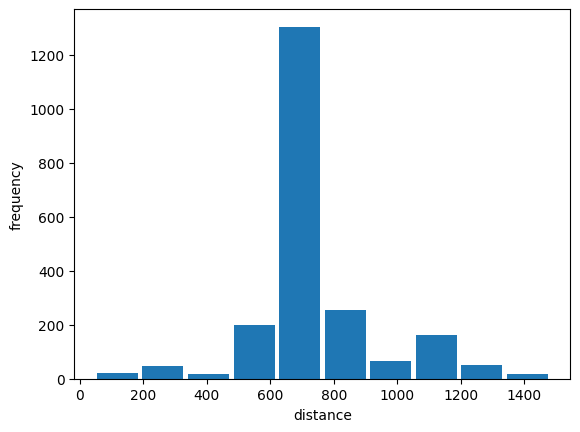

In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_r = pd.read_csv("/home/tushara/Documents/projects/phylab/elegans/analysis_code/analyzed_data/distance_over_time_new.csv", header=0)
ts = data_r.iloc[:,0].values
ds = data_r.iloc[:,1].values

plt.hist(ds, bins=10, align = "left", rwidth = 0.9)
plt.xlabel("distance")
plt.ylabel("frequency")
plt.show()

# Notes: 
**todo:**
1. take a look at image 170 -- the worms are not lost but are only very close to each other. i can fix this by writing a code that distinguishes the two worms and keeps them distinguished through the algorithm. maybe do something like based on the 0th image it edits the 1th image. this way information wont be lost i think. -- **tried fixing** _(if the area is twice +- tolerance the original area, then contour is made and then the distance is between 0 to 225 (225 is the distance for image 0169, the last image where they were close without combining into one body)_ -- It was not possible to draw line in such a case, so didn't work out. I will try distinguishing the two worms -- that's the only one that might work -- or maybe n-1 value allocation maybe.
2. watch the video at around 44 seconds -- the distance is measured b/w the smaller worm and the larger worm now
identify the image and fix it -- maybe make the circle smaller or change the tolerance **fixed** _(shifted the center of the circle a little)_
    - also here the worm at the center remains at the center while the other one is at the edge. so what i can do is -- if len(worm_contours) == 1 AND the worm is in the vicinity of the center of the circle then the distance can be recorded at the radius because that's what it is. **fixed** -- _added an if statement that checks if the center of mass falls within \pm 100 of the center of the cell -- if yes then the radius is the distance, otherwise it is lost_
3. also at 53rd second, the image is zoomed??? why???? -- **fixed** _(happened because two different sets of data -- one was taken with higher magnification -- added an if statement to recognize when the zoom happens and accordingly changes the crop)_